In [126]:
import sys
sys.path.append('../..')
import pandas as pd 
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from src.core.clients.bigquery import BigQueryClient
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries loaded successfully!")

# Load inventory data
bq_client = BigQueryClient()

df = bq_client.load_table("training_table_v3") #pd.read_csv('../artifacts/data/inventory_store_dept.csv')

# Convert date to datetime and sort
df['ctx_date_month'] = pd.to_datetime(df['ctx_date_month'])
df = df.sort_values(['ctx_store_id', 'ctx_dept_id', 'ctx_item_id', 'ctx_date_month'])

print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['ctx_date_month'].min()} to {df['ctx_date_month'].max()}")
print(f"Number of months: {df['ctx_date_month'].nunique()}")
print(f"\nUnique stores: {df['ctx_store_id'].nunique()}")
print(f"Unique departments: {df['ctx_dept_id'].nunique()}")
print(f"Unique items: {df['ctx_item_id'].nunique()}")
print(f"Store-Dept-Item combinations: {df.groupby(['ctx_store_id', 'ctx_dept_id', 'ctx_item_id']).ngroups:,}")

df.head(10)

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines


✓ Libraries loaded successfully!


INFO:src.core.clients.bigquery:Loaded 33668 rows from table: training_table_v3



Dataset shape: (33668, 368)
Date range: 2011-02-01 00:00:00 to 2016-03-01 00:00:00
Number of months: 62

Unique stores: 1
Unique departments: 1
Unique items: 822
Store-Dept-Item combinations: 822


,ctx_date_month,ctx_cat_id,ctx_dept_id,ctx_item_id,ctx_state_id,ctx_store_id,tgt_monthly_sales,tgt_monthly_sales_lead_1_months,tgt_monthly_sales_lead_2_months,tgt_monthly_sales_lead_3_months,tgt_monthly_sales_lead_4_months,tgt_days_is_zero_sales,tgt_days_is_zero_sales_lead_1_months,tgt_days_is_zero_sales_lead_2_months,tgt_days_is_zero_sales_lead_3_months,tgt_days_is_zero_sales_lead_4_months,fea_is_weekend,fea_is_event_1,fea_is_event_2,fea_is_sporting_event,fea_is_cultural_event,fea_is_national_event,fea_is_religious_event,fea_is_snap_ca,fea_is_snap_tx,fea_is_snap_wi,fea_month_sin,fea_ca_monthly_sales_roll_avg_3_months,fea_ca_monthly_sales_roll_std_3_months,fea_ca_monthly_sales_roll_avg_6_months,fea_ca_monthly_sales_roll_std_6_months,fea_ca_monthly_sales_roll_avg_12_months,fea_ca_monthly_sales_roll_std_12_months,fea_tx_monthly_sales_roll_avg_3_months,fea_tx_monthly_sales_roll_std_3_months,fea_tx_monthly_sales_roll_avg_6_months,fea_tx_monthly_sales_roll_std_6_months,fea_tx_monthly_sales_roll_avg_12_months,fea_tx_monthly_sales_roll_std_12_months,fea_wi_monthly_sales_roll_avg_3_months,fea_wi_monthly_sales_roll_std_3_months,fea_wi_monthly_sales_roll_avg_6_months,fea_wi_monthly_sales_roll_std_6_months,fea_wi_monthly_sales_roll_avg_12_months,fea_wi_monthly_sales_roll_std_12_months,fea_hobbies_monthly_sales_roll_avg_3_months,fea_hobbies_monthly_sales_roll_std_3_months,fea_hobbies_monthly_sales_roll_avg_6_months,fea_hobbies_monthly_sales_roll_std_6_months,fea_hobbies_monthly_sales_roll_avg_12_months,fea_hobbies_monthly_sales_roll_std_12_months,fea_household_monthly_sales_roll_avg_3_months,fea_household_monthly_sales_roll_std_3_months,fea_household_monthly_sales_roll_avg_6_months,fea_household_monthly_sales_roll_std_6_months,fea_household_monthly_sales_roll_avg_12_months,fea_household_monthly_sales_roll_std_12_months,fea_foods_monthly_sales_roll_avg_3_months,fea_foods_monthly_sales_roll_std_3_months,fea_foods_monthly_sales_roll_avg_6_months,fea_foods_monthly_sales_roll_std_6_months,fea_foods_monthly_sales_roll_avg_12_months,fea_foods_monthly_sales_roll_std_12_months,fea_hobbies_1_monthly_sales_roll_avg_3_months,fea_hobbies_1_monthly_sales_roll_std_3_months,fea_hobbies_1_monthly_sales_roll_avg_6_months,fea_hobbies_1_monthly_sales_roll_std_6_months,fea_hobbies_1_monthly_sales_roll_avg_12_months,fea_hobbies_1_monthly_sales_roll_std_12_months,fea_hobbies_2_monthly_sales_roll_avg_3_months,fea_hobbies_2_monthly_sales_roll_std_3_months,fea_hobbies_2_monthly_sales_roll_avg_6_months,fea_hobbies_2_monthly_sales_roll_std_6_months,fea_hobbies_2_monthly_sales_roll_avg_12_months,fea_hobbies_2_monthly_sales_roll_std_12_months,fea_household_1_monthly_sales_roll_avg_3_months,fea_household_1_monthly_sales_roll_std_3_months,fea_household_1_monthly_sales_roll_avg_6_months,fea_household_1_monthly_sales_roll_std_6_months,fea_household_1_monthly_sales_roll_avg_12_months,fea_household_1_monthly_sales_roll_std_12_months,fea_household_2_monthly_sales_roll_avg_3_months,fea_household_2_monthly_sales_roll_std_3_months,fea_household_2_monthly_sales_roll_avg_6_months,fea_household_2_monthly_sales_roll_std_6_months,fea_household_2_monthly_sales_roll_avg_12_months,fea_household_2_monthly_sales_roll_std_12_months,fea_foods_1_monthly_sales_roll_avg_3_months,fea_foods_1_monthly_sales_roll_std_3_months,fea_foods_1_monthly_sales_roll_avg_6_months,fea_foods_1_monthly_sales_roll_std_6_months,fea_foods_1_monthly_sales_roll_avg_12_months,fea_foods_1_monthly_sales_roll_std_12_months,fea_foods_2_monthly_sales_roll_avg_3_months,fea_foods_2_monthly_sales_roll_std_3_months,fea_foods_2_monthly_sales_roll_avg_6_months,fea_foods_2_monthly_sales_roll_std_6_months,fea_foods_2_monthly_sales_roll_avg_12_months,fea_foods_2_monthly_sales_roll_std_12_months,fea_foods_3_monthly_sales_roll_avg_3_months,fea_foods_3_monthly_sales_roll_std_3_months,fea_foods_3_monthly_sales_roll_avg_6_months,fea_foods_3_monthly_sales_roll_std_6_months,fea_foods_3_monthly_sales_roll_avg_12_months,fea_foods_3_monthl

## Prepare Data For Analysis

- Predict with selected model
- Create SHAP explainer
- Create absolute error

In [153]:
# Sample data for SHAP analysis (for computational efficiency)
# We'll analyze: good predictions, bad predictions, and a random sample
import yaml
import numpy as np
np.random.seed(42)

# Sample sizes
sample_size = 500
FILTER_POTENTIAL_STOCKOUT = True
STOCKOUT_DAYS_THRESHOLD = 20
# Get random sample for baseline
#random_sample = df.sample(min(1000, len(df)))

# Model name:
# MODEL_NAME = "20251119_191757"  # yesterday's
MODEL_NAME = "20251120_145507"  # with filter
loaded_model = joblib.load(f'/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/{MODEL_NAME}/model_0.joblib')

# print model information and shpa sample
print("\n" + "="*80)
print("MODEL INFO")
print("="*80)
print(f"Model type: {type(loaded_model).__name__}")
print(f"Number of features: {loaded_model.n_features_in_}")
print("="*80)
print("SAMPLE SELECTION FOR SHAP")
print("="*80)
print(f"Random baseline sample: {len(df)}")

# Create SHAP explainer
print("\nInitializing SHAP TreeExplainer...")
# Use interventional feature perturbation for XGBoost Poisson models
# This is more robust and doesn't require the background dataset to cover all tree paths
explainer = shap.TreeExplainer(loaded_model, feature_perturbation='interventional',)
print("✓ Explainer ready!")

with open('../config/features.yaml', 'r') as f:
    config = yaml.safe_load(f)
    feature_names = config['features']

# Calculate SHAP values for different samples
print("\nCalculating SHAP values for random baseline...")
available_features = [f for f in feature_names if f in df.columns]
X = df[available_features]
shap_values_random = explainer.shap_values(X)
df['predicted_label'] = loaded_model.predict(X)
df['abs_error'] = abs(df['predicted_label'] - df['tgt_monthly_sales_lead_1_months'])
df = df[~df['tgt_monthly_sales_lead_1_months'].isna()]

if FILTER_POTENTIAL_STOCKOUT:
    print(f"Filtering potential stockout rows with more than {STOCKOUT_DAYS_THRESHOLD} days of zero sales...")
    df = df[df['tgt_days_is_zero_sales_lead_1_months'] < STOCKOUT_DAYS_THRESHOLD]


MODEL INFO
Model type: XGBRegressor
Number of features: 352
SAMPLE SELECTION FOR SHAP
Random baseline sample: 28826

Initializing SHAP TreeExplainer...
✓ Explainer ready!

Calculating SHAP values for random baseline...
Filtering potential stockout rows with more than 20 days of zero sales...
Filtering potential stockout rows with more than 20 days of zero sales...


In [163]:
# find outliers:
df['tgt_monthly_sales_lead_1_months'].describe(percentiles=[0.90, 0.95, 0.97])

count    28826.0
mean      124.28
std       206.98
min          6.0
50%         62.0
90%        259.0
95%       433.75
97%       602.25
max       6814.0
Name: tgt_monthly_sales_lead_1_months, dtype: Float64

In [164]:
df['target_bins'] = pd.qcut(df['tgt_monthly_sales_lead_1_months'], q=10, duplicates="drop").apply(lambda x: f"from {x.left} to {x.right}")
df.groupby(['target_bins'])[['tgt_monthly_sales_lead_1_months']].describe()


tgt_monthly_sales_lead_1_months                         \
                                               count    mean     std    min   
target_bins                                                                   
from 5.999 to 24.0                            3201.0   19.41    3.43    6.0   
from 24.0 to 32.0                             2888.0   28.54     2.3   25.0   
from 32.0 to 40.0                             2801.0   36.39    2.28   33.0   
from 40.0 to 49.0                             2681.0   44.93    2.58   41.0   
from 49.0 to 62.0                             3025.0   55.58    3.73   50.0   
from 62.0 to 80.0                             2819.0   70.94    5.14   63.0   
from 80.0 to 108.0                            2836.0   93.42    8.03   81.0   
from 108.0 to 153.0                           2850.0  128.35   12.71  109.0   
from 153.0 to 259.0                           2845.0  197.67    30.4  154.0   
from 259.0 to 6814.0                          2880.0  574.47  419.69  260.0   

                                                   
                        25%    50%    75%     max  
target_bins                                        
from 5.999 to 24.0     17.0   20.0   22.0    24.0  
from 24.0 to 32.0      27.0   29.0   31.0    32.0  
from 32.0 to 40.0      34.0   36.0   38.0    40.0  
from 40.0 to 49.0      43.0   45.0   47.0    49.0  
from 49.0 to 62.0      52.0   56.0   59.0    62.0  
from 62.0 to 80.0      67.0   71.0   75.0    80.0  
from 80.0 to 108.0     86.0   93.0  100.0   108.0  
from 108.0 to 153.0   117.0  127.0  139.0   153.0  
from 153.0 to 259.0   171.0  193.0  222.0   259.0  
from 259.0 to 6814.0  325.0  434.0  660.0  6814.0

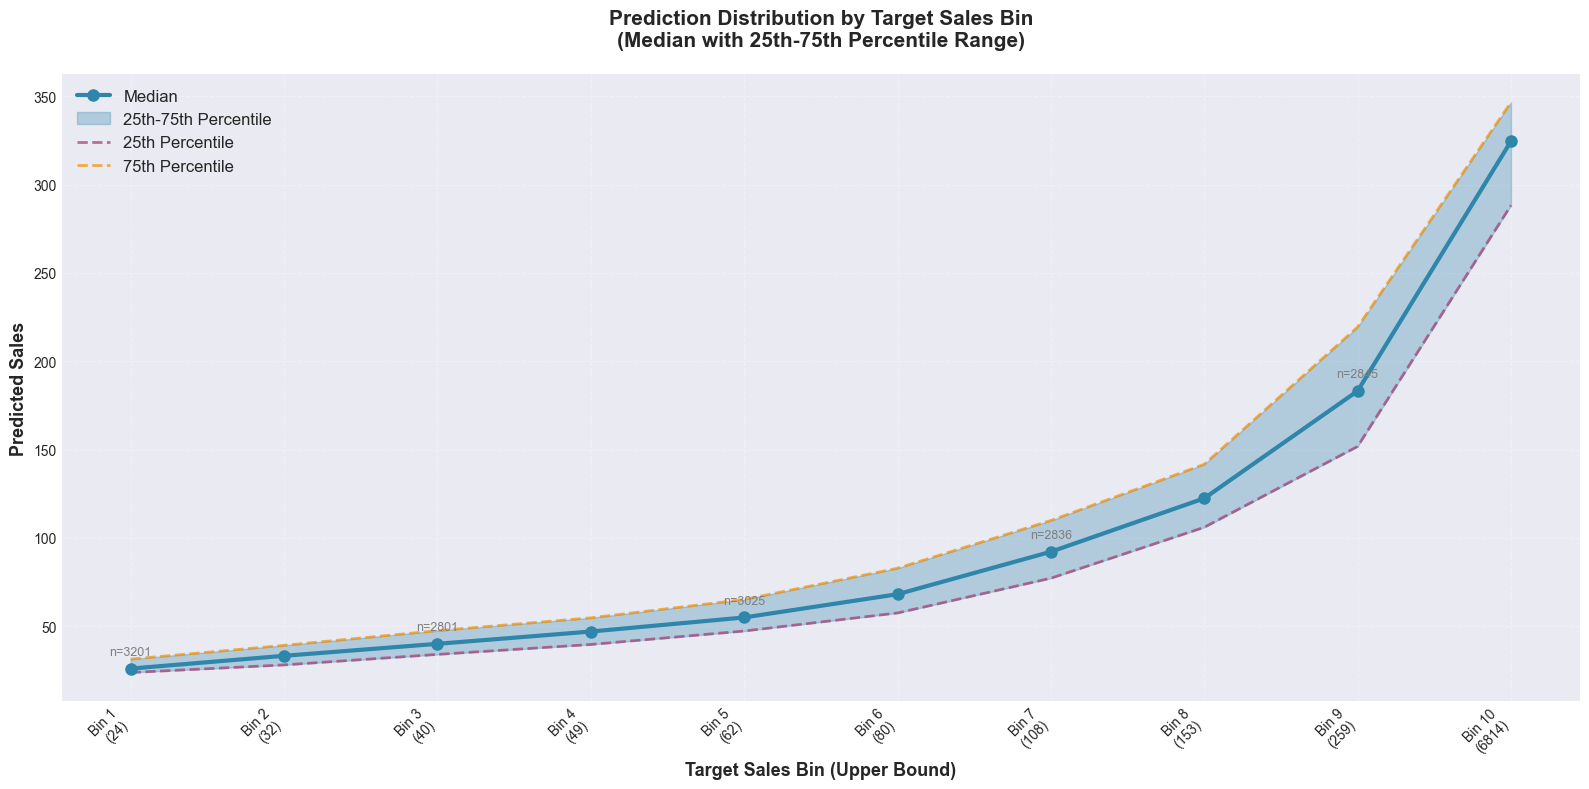


PREDICTION PERCENTILES BY TARGET BIN
    bin    p25  median    p75  count      bin_label
  24.00  23.80   26.02  31.38   3201    Bin 1\n(24)
  32.00  28.10   33.26  39.17   2888    Bin 2\n(32)
  40.00  34.05   40.04  47.49   2801    Bin 3\n(40)
  49.00  39.68   46.99  54.76   2681    Bin 4\n(49)
  62.00  47.30   54.97  65.13   3025    Bin 5\n(62)
  80.00  57.51   68.12  82.83   2819    Bin 6\n(80)
 108.00  77.19   92.17 109.86   2836   Bin 7\n(108)
 153.00 106.02  122.40 141.67   2850   Bin 8\n(153)
 259.00 151.80  183.19 219.37   2845   Bin 9\n(259)
6814.00 288.28  324.53 346.60   2880 Bin 10\n(6814)


In [165]:
# Analyze predictions by target range with percentile shading
df['target_bins'] = pd.qcut(df['tgt_monthly_sales_lead_1_months'], q=10, duplicates="drop").apply(lambda x: x.right)
df['error_bins'] = pd.qcut(df['abs_error'], q=10, duplicates="drop").apply(lambda x: x.right)

# Calculate percentiles for each bin
bins_sorted = sorted(df['target_bins'].unique())
percentiles = []

for bin_val in bins_sorted:
    bin_data = df[df['target_bins'] == bin_val]['predicted_label']
    percentiles.append({
        'bin': bin_val,
        'p25': bin_data.quantile(0.25),
        'median': bin_data.median(),
        'p75': bin_data.quantile(0.75),
        'count': len(bin_data)
    })

perc_df = pd.DataFrame(percentiles)

# Create categorical x-axis labels
perc_df['bin_label'] = [f'Bin {i+1}\n({val:.0f})' for i, val in enumerate(perc_df['bin'])]
x_positions = range(len(perc_df))

# Create line plot with shaded percentile ranges
fig, ax = plt.subplots(figsize=(16, 8))

# Plot median line
ax.plot(x_positions, perc_df['median'], 
        linewidth=3, color='#2E86AB', marker='o', markersize=8, 
        label='Median', zorder=3)

# Shade between 25th and 75th percentiles
ax.fill_between(x_positions, perc_df['p25'], perc_df['p75'], 
                alpha=0.3, color='#2E86AB', label='25th-75th Percentile')

# Plot 25th and 75th percentile lines
ax.plot(x_positions, perc_df['p25'], 
        linewidth=2, linestyle='--', color='#A23B72', alpha=0.7, 
        label='25th Percentile')
ax.plot(x_positions, perc_df['p75'], 
        linewidth=2, linestyle='--', color='#F18F01', alpha=0.7, 
        label='75th Percentile')

# Formatting
ax.set_xlabel('Target Sales Bin (Upper Bound)', fontsize=13, fontweight='bold')
ax.set_ylabel('Predicted Sales', fontsize=13, fontweight='bold')
ax.set_title('Prediction Distribution by Target Sales Bin\n(Median with 25th-75th Percentile Range)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Set categorical x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(perc_df['bin_label'])

# Add sample size annotations
for i, row in perc_df.iterrows():
    if i % 2 == 0:  # Only annotate every other bin to avoid clutter
        ax.annotate(f"n={int(row['count'])}", 
                   xy=(i, row['median']), 
                   xytext=(0, 10), textcoords='offset points',
                   fontsize=9, ha='center', color='gray')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*80}")
print("PREDICTION PERCENTILES BY TARGET BIN")
print(f"{'='*80}")
print(perc_df.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print(f"{'='*80}")

In [166]:
percentile_95 = df['tgt_monthly_sales_lead_1_months'].quantile(0.95)
print(f"95th Percentile Threshold: {percentile_95:.2f}")

95th Percentile Threshold: 433.75


95th Percentile Threshold: 427.00

DATA FILTERING SUMMARY
Original dataset size: 28,826
Filtered dataset size: 27,355
Removed outliers: 1,471 (5.10%)


MODEL PERFORMANCE METRICS (WITHOUT OUTLIERS > 95th PERCENTILE)

Primary Metrics:
  MAE (Mean Absolute Error):        16.65
  RMSE (Root Mean Squared Error):   25.75
  MAPE (Mean Absolute % Error):     24.82%
  R² (R-Squared):                    0.8926

Error Distribution:
  Mean Error (Bias):                 -0.02
  Median Error:                      2.09
  Std Dev of Error:                  25.75

Accuracy Thresholds:
  Within ±10% of actual:             31.54%
  Within ±20% of actual:             56.61%
  Within ±50% of actual:             88.48%

Target Variable Statistics:
  Mean:                              87.42
  Median:                            58.00
  Std Dev:                           78.56
  Min:                               6.00
  Max:                               427.00

Prediction Statistics:
  Mean:                  

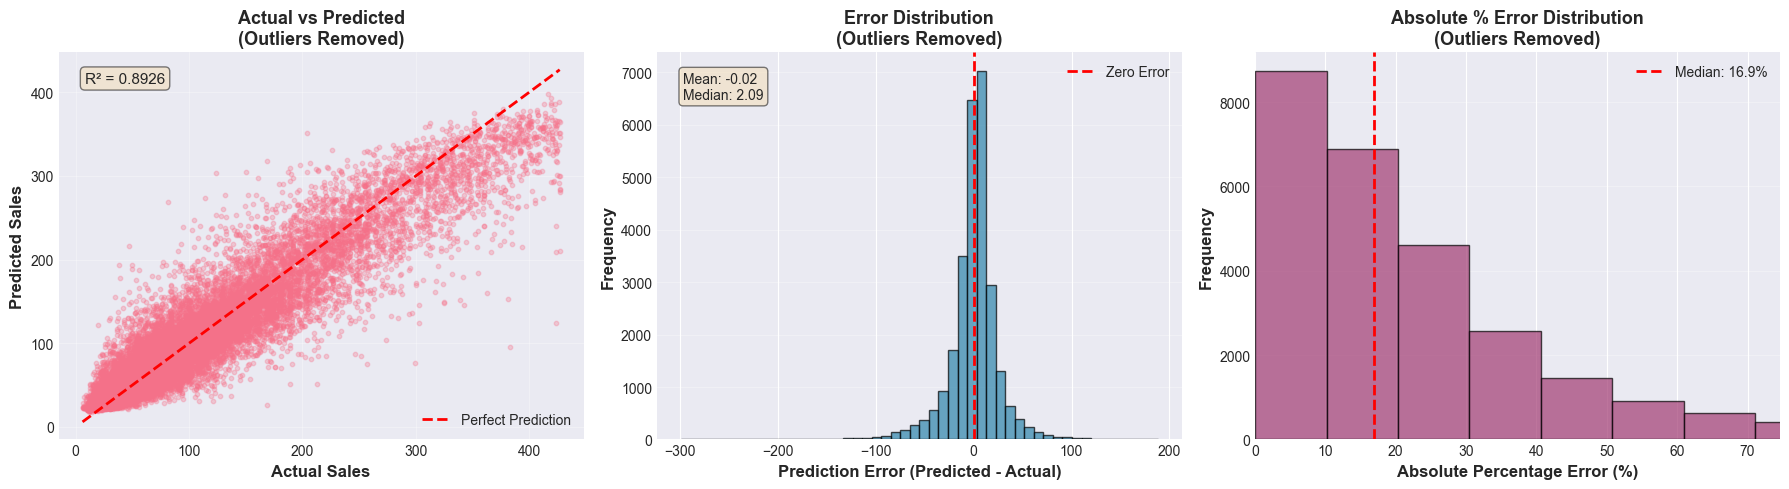

In [167]:
# Filter outliers at 95th percentile and calculate comprehensive error metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Calculate 95th percentile threshold
percentile_95 = 427 #df['tgt_monthly_sales_lead_1_months'].quantile(0.95)
print(f"95th Percentile Threshold: {percentile_95:.2f}")

# Filter data
df_filtered = df[df['tgt_monthly_sales_lead_1_months'] <= percentile_95].copy()

print(f"\n{'='*80}")
print("DATA FILTERING SUMMARY")
print(f"{'='*80}")
print(f"Original dataset size: {len(df):,}")
print(f"Filtered dataset size: {len(df_filtered):,}")
print(f"Removed outliers: {len(df) - len(df_filtered):,} ({((len(df) - len(df_filtered))/len(df)*100):.2f}%)")
print(f"{'='*80}\n")

# Calculate metrics for filtered data
y_true = df_filtered['tgt_monthly_sales_lead_1_months']
y_pred = df_filtered['predicted_label']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2 = r2_score(y_true, y_pred)

# Additional metrics
mean_error = (y_pred - y_true).mean()
median_error = (y_pred - y_true).median()
std_error = (y_pred - y_true).std()

# Percentage within thresholds
within_10_pct = (np.abs(y_pred - y_true) / y_true <= 0.10).sum() / len(y_true) * 100
within_20_pct = (np.abs(y_pred - y_true) / y_true <= 0.20).sum() / len(y_true) * 100
within_50_pct = (np.abs(y_pred - y_true) / y_true <= 0.50).sum() / len(y_true) * 100

# Print comprehensive metrics
print(f"\n{'='*80}")
print("MODEL PERFORMANCE METRICS (WITHOUT OUTLIERS > 95th PERCENTILE)")
print(f"{'='*80}")
print(f"\nPrimary Metrics:")
print(f"  MAE (Mean Absolute Error):        {mae:.2f}")
print(f"  RMSE (Root Mean Squared Error):   {rmse:.2f}")
print(f"  MAPE (Mean Absolute % Error):     {mape:.2f}%")
print(f"  R² (R-Squared):                    {r2:.4f}")

print(f"\nError Distribution:")
print(f"  Mean Error (Bias):                 {mean_error:.2f}")
print(f"  Median Error:                      {median_error:.2f}")
print(f"  Std Dev of Error:                  {std_error:.2f}")

print(f"\nAccuracy Thresholds:")
print(f"  Within ±10% of actual:             {within_10_pct:.2f}%")
print(f"  Within ±20% of actual:             {within_20_pct:.2f}%")
print(f"  Within ±50% of actual:             {within_50_pct:.2f}%")

print(f"\nTarget Variable Statistics:")
print(f"  Mean:                              {y_true.mean():.2f}")
print(f"  Median:                            {y_true.median():.2f}")
print(f"  Std Dev:                           {y_true.std():.2f}")
print(f"  Min:                               {y_true.min():.2f}")
print(f"  Max:                               {y_true.max():.2f}")

print(f"\nPrediction Statistics:")
print(f"  Mean:                              {y_pred.mean():.2f}")
print(f"  Median:                            {y_pred.median():.2f}")
print(f"  Std Dev:                           {y_pred.std():.2f}")
print(f"  Min:                               {y_pred.min():.2f}")
print(f"  Max:                               {y_pred.max():.2f}")
print(f"{'='*80}\n")

# Visualize error distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Actual vs Predicted scatter
axes[0].scatter(y_true, y_pred, alpha=0.3, s=10)
axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Sales', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Sales', fontsize=12, fontweight='bold')
axes[0].set_title('Actual vs Predicted\n(Outliers Removed)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Residual distribution
residuals = y_pred - y_true
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error (Predicted - Actual)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Error Distribution\n(Outliers Removed)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].text(0.05, 0.95, f'Mean: {mean_error:.2f}\nMedian: {median_error:.2f}', 
            transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Absolute percentage error distribution
abs_pct_error = np.abs((y_pred - y_true) / y_true) * 100
axes[2].hist(abs_pct_error, bins=50, edgecolor='black', alpha=0.7, color='#A23B72')
axes[2].axvline(abs_pct_error.median(), color='red', linestyle='--', linewidth=2, 
               label=f'Median: {abs_pct_error.median():.1f}%')
axes[2].set_xlabel('Absolute Percentage Error (%)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[2].set_title('Absolute % Error Distribution\n(Outliers Removed)', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_xlim(0, min(abs_pct_error.quantile(0.95), 200))

plt.tight_layout()
plt.show()


In [168]:
df['ctx_item_id'].unique()

array(['FOODS_3_001', 'FOODS_3_002', 'FOODS_3_003', 'FOODS_3_004',
       'FOODS_3_005', 'FOODS_3_006', 'FOODS_3_007', 'FOODS_3_008',
       'FOODS_3_009', 'FOODS_3_010', 'FOODS_3_011', 'FOODS_3_012',
       'FOODS_3_013', 'FOODS_3_014', 'FOODS_3_015', 'FOODS_3_016',
       'FOODS_3_018', 'FOODS_3_019', 'FOODS_3_020', 'FOODS_3_021',
       'FOODS_3_022', 'FOODS_3_023', 'FOODS_3_024', 'FOODS_3_025',
       'FOODS_3_026', 'FOODS_3_027', 'FOODS_3_028', 'FOODS_3_029',
       'FOODS_3_030', 'FOODS_3_031', 'FOODS_3_032', 'FOODS_3_033',
       'FOODS_3_034', 'FOODS_3_035', 'FOODS_3_036', 'FOODS_3_037',
       'FOODS_3_038', 'FOODS_3_039', 'FOODS_3_040', 'FOODS_3_041',
       'FOODS_3_042', 'FOODS_3_043', 'FOODS_3_044', 'FOODS_3_045',
       'FOODS_3_046', 'FOODS_3_047', 'FOODS_3_048', 'FOODS_3_049',
       'FOODS_3_050', 'FOODS_3_051', 'FOODS_3_053', 'FOODS_3_054',
       'FOODS_3_055', 'FOODS_3_056', 'FOODS_3_057', 'FOODS_3_058',
       'FOODS_3_059', 'FOODS_3_060', 'FOODS_3_061', 'FOODS_3_0

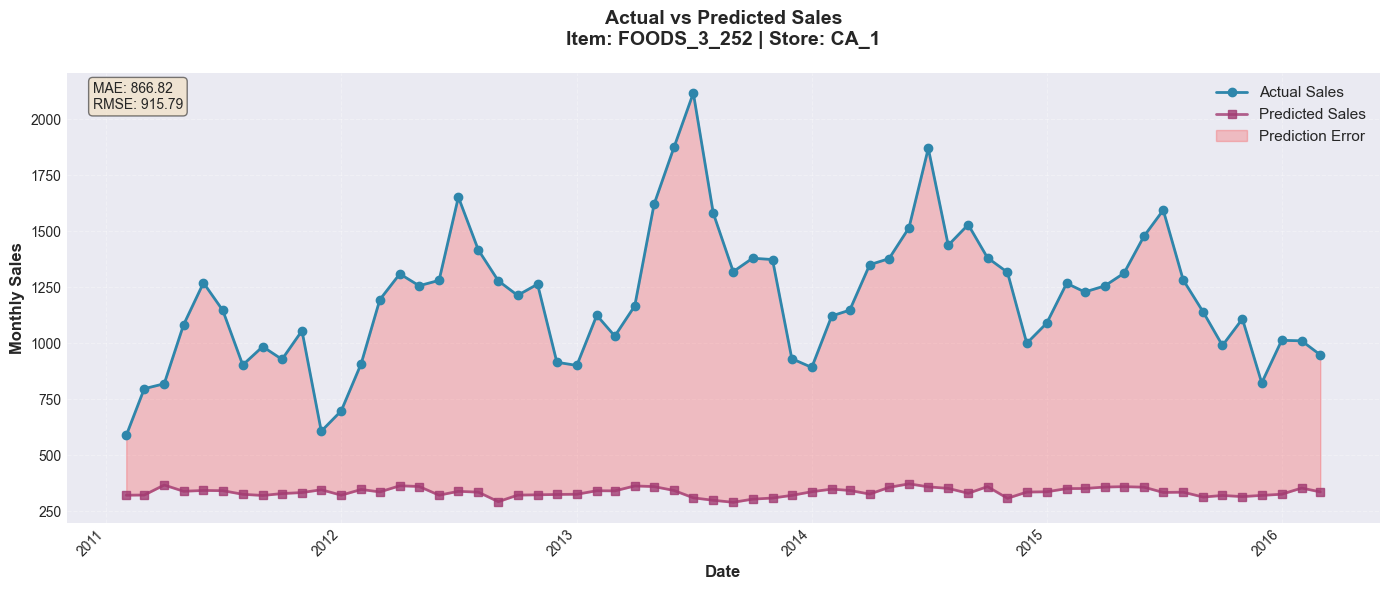


ITEM: FOODS_3_252 | STORE: CA_1 - Summary Statistics
Date Range: 2011-02-01 to 2016-03-01
Number of months: 62

Actual Sales:
  Mean: 1201.47
  Std: 298.89
  Min: 588.00
  Max: 2118.00

Predicted Sales:
  Mean: 334.65
  Std: 18.96
  Min: 289.33
  Max: 371.85

Error Metrics:
  MAE: 866.82
  RMSE: 915.79
  MAPE: 70.36%


In [169]:
ITEM_ID = 'FOODS_3_252'

item_store_data = df[(df['ctx_item_id']==ITEM_ID) & (df['ctx_store_id']=='CA_1')].copy()
item_store_data = item_store_data.sort_values('ctx_date_month').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual vs predicted
ax.plot(item_store_data['ctx_date_month'], item_store_data['tgt_monthly_sales_lead_1_months'], 
        marker='o', linewidth=2, markersize=6, label='Actual Sales', color='#2E86AB')
ax.plot(item_store_data['ctx_date_month'], item_store_data['predicted_label'], 
        marker='s', linewidth=2, markersize=6, label='Predicted Sales', color='#A23B72', alpha=0.8)

# Fill between to show error
ax.fill_between(item_store_data['ctx_date_month'], 
                item_store_data['tgt_monthly_sales_lead_1_months'], 
                item_store_data['predicted_label'], 
                alpha=0.2, color='red', label='Prediction Error')

# Formatting
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Monthly Sales', fontsize=12, fontweight='bold')
ax.set_title(f'Actual vs Predicted Sales\nItem: {ITEM_ID} | Store: CA_1', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

# Add error metrics
mae = abs(item_store_data['tgt_monthly_sales_lead_1_months'] - item_store_data['predicted_label']).mean()
rmse = np.sqrt(((item_store_data['tgt_monthly_sales_lead_1_months'] - item_store_data['predicted_label'])**2).mean())
ax.text(0.02, 0.98, f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"ITEM: {ITEM_ID} | STORE: CA_1 - Summary Statistics")
print(f"{'='*60}")
print(f"Date Range: {item_store_data['ctx_date_month'].min().date()} to {item_store_data['ctx_date_month'].max().date()}")
print(f"Number of months: {len(item_store_data)}")
print(f"\nActual Sales:")
print(f"  Mean: {item_store_data['tgt_monthly_sales_lead_1_months'].mean():.2f}")
print(f"  Std: {item_store_data['tgt_monthly_sales_lead_1_months'].std():.2f}")
print(f"  Min: {item_store_data['tgt_monthly_sales_lead_1_months'].min():.2f}")
print(f"  Max: {item_store_data['tgt_monthly_sales_lead_1_months'].max():.2f}")
print(f"\nPredicted Sales:")
print(f"  Mean: {item_store_data['predicted_label'].mean():.2f}")
print(f"  Std: {item_store_data['predicted_label'].std():.2f}")
print(f"  Min: {item_store_data['predicted_label'].min():.2f}")
print(f"  Max: {item_store_data['predicted_label'].max():.2f}")
print(f"\nError Metrics:")
print(f"  MAE: {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAPE: {(abs(item_store_data['tgt_monthly_sales_lead_1_months'] - item_store_data['predicted_label']) / item_store_data['tgt_monthly_sales_lead_1_months'].replace(0, np.nan)).mean() * 100:.2f}%")
print(f"{'='*60}")

In [170]:

# Interactive table to help select a date for SHAP analysis
print(f"\n{'='*90}")
print("SELECT A DATE FOR SHAP ANALYSIS")
print(f"{'='*90}")

selection_df = item_store_data[['ctx_date_month', 'tgt_monthly_sales_lead_1_months', 
                                  'predicted_label', 'abs_error', 
                                  'tgt_days_is_zero_sales_lead_1_months']].copy()
selection_df['ctx_date_month_str'] = selection_df['ctx_date_month'].dt.strftime('%Y-%m-%d')
selection_df = selection_df.rename(columns={
    'ctx_date_month_str': 'Date',
    'tgt_monthly_sales_lead_1_months': 'Actual',
    'predicted_label': 'Predicted',
    'abs_error': 'Error',
    'tgt_days_is_zero_sales_lead_1_months': 'Zero_Days'
})

display_cols = ['Date', 'Actual', 'Predicted', 'Error', 'Zero_Days']
print(selection_df[display_cols].to_string(index=True))
print(f"\n{'='*90}")
print("💡 Pick a row index from above and use it in the next cell:")
print("   Example: selected_date = item_store_data.iloc[5]['ctx_date_month']")
print(f"{'='*90}\n")


SELECT A DATE FOR SHAP ANALYSIS
          Date  Actual  Predicted    Error  Zero_Days
0   2011-02-01     588     321.04   266.96          0
1   2011-03-01     797     321.82   475.18          0
2   2011-04-01     819     366.52   452.48          0
3   2011-05-01    1082     338.65   743.35          0
4   2011-06-01    1270     342.29   927.71          0
5   2011-07-01    1147     341.30    805.7          0
6   2011-08-01     903     325.11   577.89          0
7   2011-09-01     985     319.86   665.14          0
8   2011-10-01     928     328.35   599.65          0
9   2011-11-01    1056     332.86   723.14          1
10  2011-12-01     607     345.45   261.55          0
11  2012-01-01     698     321.15   376.85          0
12  2012-02-01     909     346.60    562.4          0
13  2012-03-01    1195     335.71   859.29          0
14  2012-04-01    1310     363.23   946.77          0
15  2012-05-01    1257     359.90    897.1          0
16  2012-06-01    1281     321.18   959.82       

In [171]:
# SELECT YOUR DATE HERE - Change the index number to pick a different date
SELECTED_DATE = "2015-11-01"
item_store_data_date = item_store_data[item_store_data['ctx_date_month']==SELECTED_DATE]

print(f"\n{'='*70}")
print(f"SELECTED DATE: {pd.Timestamp(SELECTED_DATE).strftime('%Y-%m-%d')}")
print(f"{'='*70}")
print(f"Actual Sales: {item_store_data_date['tgt_monthly_sales_lead_1_months'].values[0]:.2f}")
print(f"Predicted Sales: {item_store_data_date['predicted_label'].values[0]:.2f}")
print(f"Error: {item_store_data_date['abs_error'].values[0]:.2f}")
print(f"Zero Sales Days (Lead 1m): {item_store_data_date['tgt_days_is_zero_sales_lead_1_months'].values[0]:.0f}")
print(f"{'='*70}\n")

shap_values_item_store_date = explainer.shap_values(item_store_data_date[available_features])

# Get prediction for this sample
prediction = loaded_model.predict(item_store_data_date[available_features])[0]

# Convert SHAP values from 2D array to 1D (flatten the single row)
shap_values_flat = shap_values_item_store_date.flatten()

shap_importance_bad = pd.DataFrame({
    'prediction': prediction,
    'actuals': item_store_data_date["tgt_monthly_sales_lead_1_months"].values[0],    
    'feature': available_features,
    'feature_value': item_store_data_date[available_features].values[0],
    'shap_value': shap_values_flat,
    'abs_shap': np.abs(shap_values_flat)
}).sort_values('abs_shap', ascending=False)

shap_importance_bad.head(50)



SELECTED DATE: 2015-11-01
Actual Sales: 1109.00
Predicted Sales: 314.82
Error: 794.18
Zero Sales Days (Lead 1m): 1



,prediction,actuals,feature,feature_value,shap_value,abs_shap
303,314.82,1109,fea_item_monthly_sales,990,122.28,122.28
307,314.82,1109,fea_item_monthly_sales_roll_avg_12_months,1257.0,39.39,39.39
305,314.82,1109,fea_item_monthly_sales_roll_avg_3_months,1252.0,38.97,38.97
308,314.82,1109,fea_item_monthly_sales_roll_std_3_months,258.07,-7.09,7.09
311,314.82,1109,fea_item_monthly_sales_lag_1_months,1140,5.52,5.52
340,314.82,1109,fea_all_item_num_days_is_zero_sales,0,4.68,4.68
306,314.82,1109,fea_item_monthly_sales_roll_avg_6_months,1293.57,4.09,4.09
339,314.82,1109,fea_all_item_monthly_sales,8154,4.09,4.09
325,314.82,1109,fea_state_item_monthly_sales,3718,3.74,3.74
332,314.82,1109,fea_state_item_monthly_sales_roll_std_12_months,875.21,3.29,3.29
